# Figure 1 Final

Notebook to make figure 1 for ms <br>
by Cascade Tuholske 2020.02.23

In [1]:
#### Depdencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from matplotlib import rcParams
import os

In [2]:
#### Load Data
DATA = 'himax461' # UPDATE 

# file paths
DATA_IN = '/scratch/cascade/UEH-daily/stats/'  
FIG_OUT = '/home/cascade/projects/UrbanHeat/figures/'
FN_IN = os.path.join(DATA_IN,DATA+'_EXP.json') # all, not p05 since this is global
HI_STATS = pd.read_json(FN_IN, orient = 'split')

# Set scale
scale = 10**9

# File out
FN_OUT = os.path.join(FIG_OUT,'FIG4-'+DATA+'-Final.tiff')

In [3]:
# Check it
HI_STATS.head()

,ID_HDC_G0,year,tot_days,P,P1983,P2016,people_days,people_days_heat,people_days_pop
0,29,1996,1,370634.089508,336518.836621,533318.453653,370634.089508,336518.836621,34115.252887
1,33,2006,2,52767.331426,40107.651544,61668.587152,105534.662852,80215.303088,25319.359764
2,34,2006,3,312619.480563,236515.041712,365617.969896,937858.441690,709545.125135,228313.316556
3,35,2006,2,265319.341234,224762.325023,297123.339094,530638.682468,449524.650046,81114.032423
4,38,1996,1,41409.070966,38122.169854,52276.761932,41409.070966,38122.169854,3286.901112


In [4]:
# Drop IDs where days 1983 = 1 with none else. throws error in regressions 

print(len(HI_STATS))
only83 = HI_STATS.groupby('ID_HDC_G0')['tot_days'].sum() == 1 # sum up total days and find those with 1 day
only83 = list(only83[only83 == True].index) # make a list of IDs
sub = HI_STATS[HI_STATS['ID_HDC_G0'].isin(only83)] # subset those IDs
bad_ids = sub[(sub['year'] == 1983) & (sub['tot_days'] == 1)] # drop those from 1983 only
drop_list = list(bad_ids['ID_HDC_G0']) # make a list
HI_STATS= HI_STATS[~HI_STATS['ID_HDC_G0'].isin(drop_list)] # drop those from the list
print(len(HI_STATS))

222054
221646


In [5]:
#### Regressions, no intercept addition is needed because we're using SK LEARN HERE 

def lm_func(df, col):
    
    "simple linear model of a time series data, returns coef"
    
    # Get Data
    X_year = np.array(df.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df.groupby('year')[col].sum()).reshape((-1, 1))

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit() 
        
    coef = int(model.params[1])
    #coef = int(coef)
            
    # R2 and P
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    return coef, round(r2, 2), round(p, 3)

In [6]:
yr_range = max(HI_STATS['year']) - min(HI_STATS['year']) + 1

In [ ]:
#### Regional-level code

## Add In Meta Data
# geog = ['region', 'intermediate-region', 'sub-region','CTR_MN_NM', 'ID_HDC_G0', 'GCPNT_LAT', 'GCPNT_LON']
# meta_fn = 'processed/AllDATA-GHS-ERA5-HI406-META.csv'
# all_data = pd.read_csv(DATA_IN+meta_fn)
# meta = all_data[geog]
# meta = meta.drop_duplicates('ID_HDC_G0')

## Merge it
# HI_STATS = HI_STATS.merge(meta, on = 'ID_HDC_G0', how = 'inner')

## Select Data
# geog = 'region'
# location = 'Africa' 
# FN_OUT = 'FIG1-ERA5-'+location+'.png'
# HI_STATS = HI_STATS[HI_STATS[geog] == location]

Text(2.5, 1.1, '(C)')

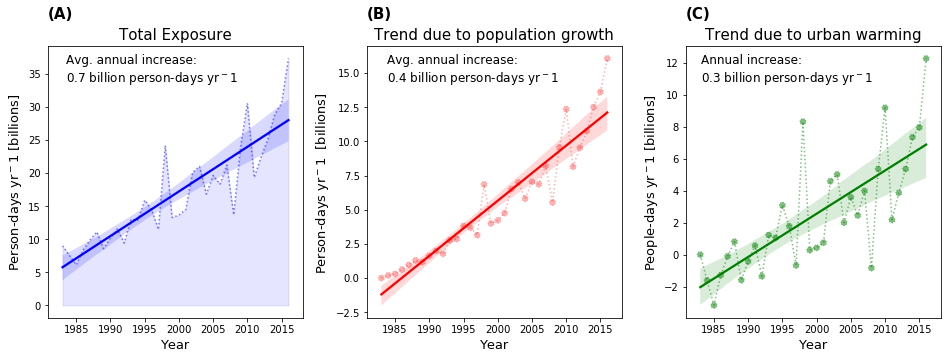

In [7]:
#### Make Figure & Save it

rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 

fig, axs = plt.subplots(1, 3, figsize = (16, 5), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)

## Years to calc increase in pdays / yr 
## yr_range = max(HI_STATS['year']) - min(HI_STATS['year']) + 1

## PLOT 1 - People Days
color = 'blue'
data = HI_STATS.groupby('year')['people_days'].sum() / scale
years = list(data.index)
axs[0].plot(data, color = color, linestyle = ':', alpha = 0.5)
axs[0].fill_between(years, data, color = color, alpha = 0.1, label='_nolegend_')
sns.regplot(years, data, color = color, ax = axs[0], scatter = False, truncate = True)
axs[0].set_title('Total Exposure', size = 15 )
axs[0].set_ylabel('Person-days $yr^-1$ [billions]', fontsize = 13)
axs[0].set_xlabel('Year', fontsize = 13)

# Add text
coef, r2, p = lm_func(HI_STATS, 'people_days')
#text = str(round(coef/1000*yr_range, 1))+' B increase in\nperson-days'# ($R^2$=' + str(r2) + ')*'
text = 'Avg. annual increase:\n'+str(round(coef/10**9, 1))+' billion person-days $yr^-1$'
axs[0].text(0.07, .87, text, transform=axs[0].transAxes, size=12)
axs[0].text(0.00, 1.1, '(A)', transform=axs[0].transAxes, size=15, fontweight='bold')

## 2 PLOT 2 - People Days delta pop x days
color = 'red'
data = HI_STATS.groupby('year')['people_days_pop'].sum() / scale
axs[1].scatter(years, data, color = color, linestyle = ':', alpha = 0.3)
axs[1].plot(data, color = color, linestyle = ':', alpha = 0.3)
sns.regplot(years, data, color = color, ax = axs[1], scatter = False, truncate = True)
axs[1].set_title('Trend due to population growth', size = 15)
axs[1].set_ylabel('Person-days $yr^-1$  [billions] ', fontsize = 13)
axs[1].set_xlabel('Year', fontsize = 13)

# Add text
coef, r2, p = lm_func(HI_STATS, 'people_days_pop')
#text = str(round(coef/1000*yr_range, 1))+' B increase in\nperson-days'# ($R^2$=' + str(r2) + ')*'
text = 'Avg. annual increase:\n'+str(round(coef/10**9, 1))+' billion person-days $yr^-1$'
axs[1].text(1.25+.08, .87, text, transform=axs[0].transAxes, size=12)
axs[1].text(1.25, 1.1, '(B)', transform=axs[0].transAxes, size=15, fontweight='bold')

## PLOT 3 - People Days due to heat
color = 'green'
data = HI_STATS.groupby('year')['people_days_heat'].sum() / scale
pdays83 = data.get(data.index[0])
data = data - pdays83
years = list(data.index)
axs[2].scatter(years, data, color = color, linestyle = ':', alpha = 0.5)
axs[2].plot(data, color = color, linestyle = ':', alpha = 0.5)
sns.regplot(years, data, color = color, ax = axs[2], scatter = False, truncate = True)
axs[2].set_title('Trend due to urban warming', size = 15)
axs[2].set_xlabel('Year', fontsize = 13)
axs[2].set_ylabel('People-days $yr^-1$ [billions]', fontsize = 13)

# Add text
coef, r2, p = lm_func(HI_STATS, 'people_days_heat')
text = 'Annual increase:\n'+str(round(coef/10**9, 1))+' billion person-days $yr^-1$'
axs[2].text(1.25*2-0.04+.1, .87, text, transform=axs[0].transAxes, size=12,);
axs[1].text(1.25*2, 1.1, '(C)', transform=axs[0].transAxes, size=15, fontweight='bold')

# save it out
#plt.savefig(FN_OUT, dpi = 300, bbox_inches='tight')

